In [1]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [2]:
# Step 1: Load the Dataset
apps_df = pd.read_csv('Play Store Data.csv')
reviews_df = pd.read_csv('User Reviews.csv')

In [3]:
# Step 2: Data Cleaning
apps_df = apps_df.dropna(subset=['Rating'])
for column in apps_df.columns:
    apps_df[column].fillna(apps_df[column].mode()[0], inplace=True)
apps_df.drop_duplicates(inplace=True)
apps_df = apps_df[apps_df['Rating'] <= 5]
reviews_df.dropna(subset=['Translated_Review'], inplace=True)

In [4]:
# Merge datasets on 'App' and handle non-matching apps
merged_df = pd.merge(apps_df, reviews_df, on='App', how='inner')

In [5]:
# Step 3: Data Transformation
apps_df['Reviews'] = apps_df['Reviews'].astype(int)
apps_df['Installs'] = apps_df['Installs'].str.replace(',', '').str.replace('+', '').astype(int)
apps_df['Price'] = apps_df['Price'].str.replace('$', '').astype(float)

In [6]:
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1024
    else:
        return np.nan

In [7]:
apps_df['Size'] = apps_df['Size'].apply(convert_size)


In [8]:
# Add Rating Group column
def rating_group(rating):
    if rating >= 4:
        return 'Top rated'
    elif rating >= 3:
        return 'Above average'
    elif rating >= 2:
        return 'Average'
    else:
        return 'Below average'

apps_df['Rating_Group'] = apps_df['Rating'].apply(rating_group)

In [9]:
# Add Revenue column
apps_df['Revenue'] = apps_df['Price'] * apps_df['Installs']


In [10]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
reviews_df['Sentiment_Score'] = reviews_df['Translated_Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

In [11]:
# Extract year from 'Last Updated' and create 'Year' column
apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')
apps_df['Year'] = apps_df['Last Updated'].dt.year

AttributeError: module 'seaborn' has no attribute 'histplot'

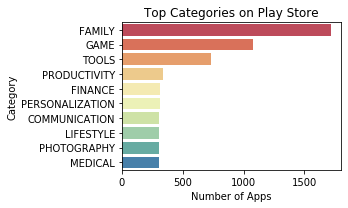

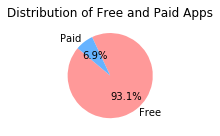

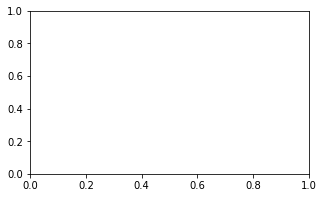

In [12]:
# Create Tkinter window
class AppDashboard(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Google Play Store Analysis Dashboard")
        self.geometry("1200x800")
        self.configure(bg='lightgray')

        # Create a main canvas and scrollbars
        main_frame = tk.Frame(self)
        main_frame.pack(fill=tk.BOTH, expand=True)

        canvas = tk.Canvas(main_frame, bg='lightgray')
        v_scrollbar = ttk.Scrollbar(main_frame, orient="vertical", command=canvas.yview)
        h_scrollbar = ttk.Scrollbar(main_frame, orient="horizontal", command=canvas.xview)
        
        v_scrollbar.pack(side="right", fill="y")
        h_scrollbar.pack(side="bottom", fill="x")
        canvas.pack(side="left", fill="both", expand=True)
        
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )

        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=v_scrollbar.set, xscrollcommand=h_scrollbar.set)

        # Create a grid layout for the dashboard
        for i in range(6):
            scrollable_frame.columnconfigure(i, weight=1)

        # Create and place frames for each visualization
        self.create_category_analysis(scrollable_frame, 0, 0)
        self.create_type_analysis(scrollable_frame, 0, 1)
        self.create_rating_sentiment_analysis(scrollable_frame, 0, 2)
        self.create_installation_update_analysis(scrollable_frame, 0, 3)
        self.create_additional_insights(scrollable_frame, 0, 4)
        self.create_ml_model_evaluation(scrollable_frame, 0, 5)

    def create_category_analysis(self, parent, row, column):
        frame = ttk.Frame(parent, padding="5")
        frame.grid(row=row, column=column, sticky="nsew", pady=5)
        frame.columnconfigure(0, weight=1)

        category_counts = apps_df['Category'].value_counts().nlargest(10)
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.barplot(x=category_counts.values, y=category_counts.index, palette='Spectral', ax=ax)
        ax.set_title('Top Categories on Play Store')
        ax.set_xlabel('Number of Apps')
        ax.set_ylabel('Category')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

    def create_type_analysis(self, parent, row, column):
        frame = ttk.Frame(parent, padding="5")
        frame.grid(row=row, column=column, sticky="nsew", pady=5)
        frame.columnconfigure(0, weight=1)

        type_counts = apps_df['Type'].value_counts()
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff'])
        ax.set_title('Distribution of Free and Paid Apps')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

    def create_rating_sentiment_analysis(self, parent, row, column):
        frame = ttk.Frame(parent, padding="5")
        frame.grid(row=row, column=column, sticky="nsew", pady=5)
        frame.columnconfigure(0, weight=1)

        fig, ax = plt.subplots(figsize=(5, 3))
        sns.histplot(apps_df['Rating'], bins=30, kde=True, color='purple', ax=ax)
        ax.set_title('Rating Distribution')
        ax.set_xlabel('Rating')
        ax.set_ylabel('Frequency')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

        sentiment_counts = reviews_df['Sentiment_Score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')).value_counts()
        fig, ax = plt.subplots(figsize=(3, 2))
        ax.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#99ff99', '#66ffcc'])
        ax.set_title('Sentiment Distribution')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

    def create_installation_update_analysis(self, parent, row, column):
        frame = ttk.Frame(parent, padding="5")
        frame.grid(row=row, column=column, sticky="nsew", pady=5)
        frame.columnconfigure(0, weight=1)

        installs_by_category = apps_df.groupby('Category')['Installs'].sum().nlargest(10)
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.barplot(x=installs_by_category.values, y=installs_by_category.index, palette='coolwarm', ax=ax)
        ax.set_title('Installations by Category')
        ax.set_xlabel('Number of Installations')
        ax.set_ylabel('Category')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

        updates_over_year = apps_df['Year'].value_counts().sort_index()
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.lineplot(x=updates_over_year.index, y=updates_over_year.values, marker='o', ax=ax)
        ax.set_title('Distribution of App Updates Over the Year')
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Updates')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

    def create_additional_insights(self, parent, row, column):
        frame = ttk.Frame(parent, padding="5")
        frame.grid(row=row, column=column, sticky="nsew", pady=5)
        frame.columnconfigure(0, weight=1)

        revenue_by_category = apps_df.groupby('Category')['Revenue'].sum().nlargest(10)
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.barplot(x=revenue_by_category.values, y=revenue_by_category.index, palette='viridis', ax=ax)
        ax.set_title('Revenue by Category')
        ax.set_xlabel('Revenue')
        ax.set_ylabel('Category')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

        genres_counts = apps_df['Genres'].str.split(';').explode().value_counts().nlargest(10)
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.barplot(x=genres_counts.values, y=genres_counts.index, palette='magma', ax=ax)
        ax.set_title('Top Genres on Play Store')
        ax.set_xlabel('Number of Apps')
        ax.set_ylabel('Genres')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

        fig, ax = plt.subplots(figsize=(5, 3))
        sns.boxplot(data=apps_df, x='Year', y='Rating', palette='cool', ax=ax)
        ax.set_title('Effect of Last Update on Rating')
        ax.set_xlabel('Year')
        ax.set_ylabel('Rating')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

        fig, ax = plt.subplots(figsize=(5, 3))
        sns.boxplot(data=apps_df, x='Type', y='Rating', palette='Set2', ax=ax)
        ax.set_title('Ratings for Paid vs Free Apps')
        ax.set_xlabel('Type')
        ax.set_ylabel('Rating')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

    def create_ml_model_evaluation(self, parent, row, column):
        frame = ttk.Frame(parent, padding="5")
        frame.grid(row=row, column=column, sticky="nsew", pady=5)
        frame.columnconfigure(0, weight=1)

        X = apps_df[['Log_Reviews', 'Log_Installs', 'Price']]
        y = apps_df['Rating']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        fig, ax = plt.subplots(figsize=(5, 3))
        ax.scatter(y_test, y_pred, alpha=0.3)
        ax.plot([0, 5], [0, 5], 'r--')
        ax.set_title(f'ML Model Evaluation (MSE: {mse:.2f}, R2: {r2:.2f})')
        ax.set_xlabel('True Rating')
        ax.set_ylabel('Predicted Rating')
        fig.tight_layout()
        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack(expand=True, fill="both")

if __name__ == "__main__":
    app = AppDashboard()
    app.mainloop()